In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Classification illustration with artificially noisy GPS data

The data below comes from  GPS data taken from [www.openstreetmap.org/traces/tag/Berlin](https://www.openstreetmap.org/traces/tag/Berlin). 

To get a similarity with the mobile device signalling data, the data was modified:
* long gaps in the GPS trace were removed
* a fraction of events were duplicated
* gaussian noise was added to the locations

## Start with trace

The trace has already been processed. Notebooks available in the notebooks branch contain the methods used to pre-process the data.

In [2]:
import pandas as pd
import numpy as np
import datetime

In [3]:
df = pd.read_csv('./2778884_noise.csv')

In [4]:
home_coords = [0.55*df.lat.max()+0.45*df.lat.min(), 0.5*(df.lon.max()+df.lon.min())] 

In [5]:
import folium

colors = ['green','darkgreen','lightgreen','darkblue','lightblue',
          'red','blue','gray','darkred','orange','beige',
          'purple','pink','cadetblue','lightgray','black'] 
# 'lightred','darkpurple'

In [6]:
m = folium.Map(location=home_coords, width='60%', height='100%', top='0%',
                   zoom_start=13, tiles='CartoDBpositron', control_scale=True)

len_colors=len(colors)

lons = df.lon.values
lats = df.lat.values
coords = list(zip(lats,lons))


offset=40
range_ =51

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    folium.PolyLine(coco, color=colors[n%len_colors]).add_to(m)    
m    

`m.save("../../docs/illustration/map.html")`

## Apply projections and plot in 2D1T

Transform the noisy GPS data from WGS84 coordinate systems to a local coordinate system with meter resolution. 

In [7]:
import pyproj as proj

# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj(init='epsg:27700') # use a locally appropriate projected CRS

In [8]:
plons, plats = proj.transform(crs_wgs, crs_bng, lons, lats)

In [9]:
df['time'] = pd.to_datetime(df['time'])

In [10]:
times = df.time.values

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

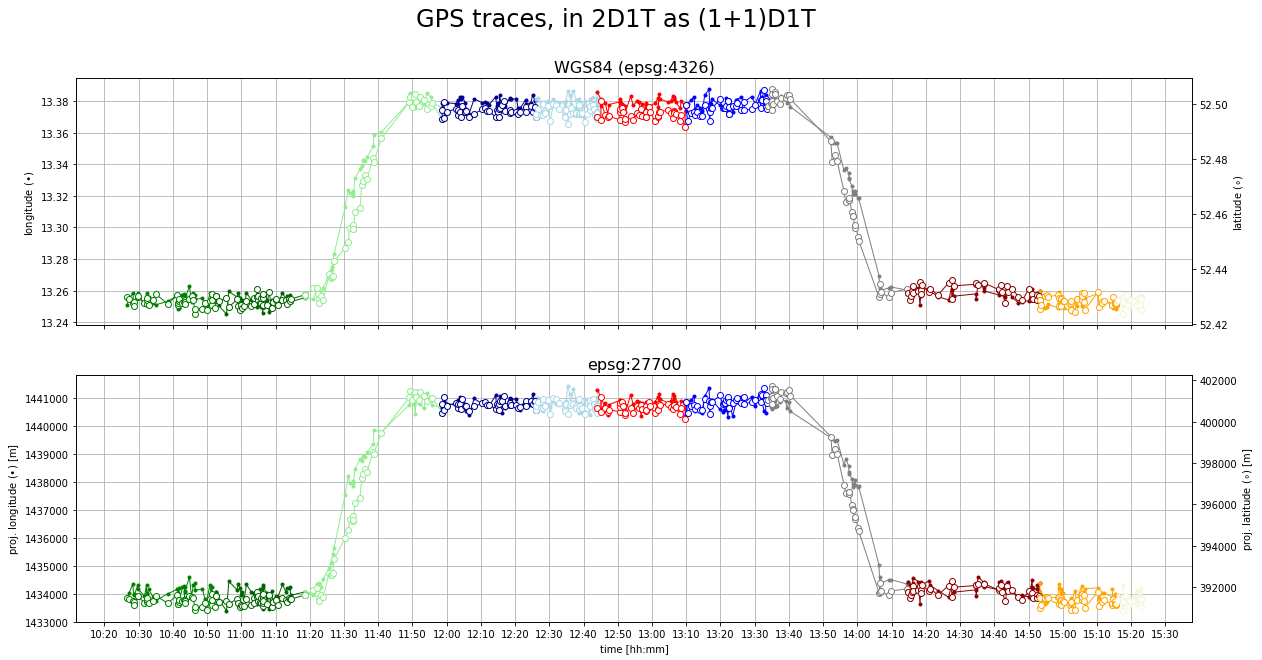

In [154]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, axs= plt.subplots(2,1, figsize=[20,10])


axs = axs.flatten()

ax = axs[0]

axt = ax.twinx()

offset=40
range_ =51
for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]

    ax.plot(times[nn:nnn], lons[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(times[nn:nnn], lats[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    
ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

ax = axs[1]
axt = ax.twinx()

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    ax.plot(times[nn:nnn], plons[nn:nnn], '.-', color=color, lw=1)
    axt.plot(times[nn:nnn], plats[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=color, lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$) [m]")
ax.set_ylabel(r"proj. longitude ($\bullet$) [m]")
ax.set_xlabel("time [hh:mm]")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);

## Shift & Scale transforms

In [155]:
from matplotlib import ticker

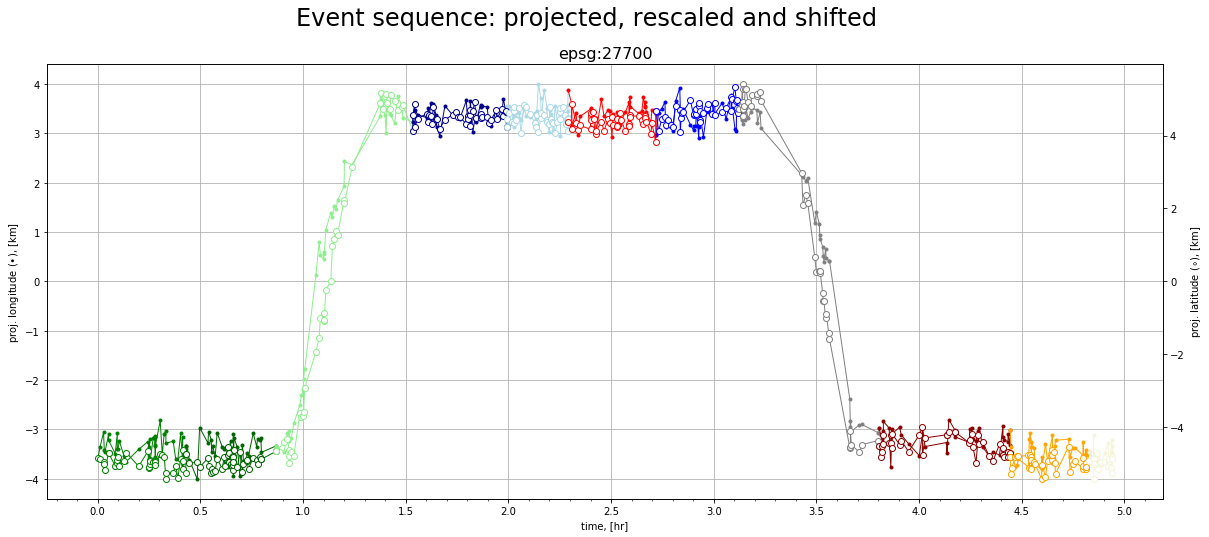

In [156]:
fig, ax = plt.subplots(1,1, figsize=[20,8])

axt = ax.twinx()

# shift and rescale the coordinates (from meters to km)
nplons = (plons-(plons.max()+plons.min())/2)/1000. #np.median(plon)
nplats = (plats-(plats.max()+plats.min())/2)/1000. #np.median(plat)

# Shift the timestamps (no necessary, but convenient)
stamps = df.timestamp.values
stamps = (stamps-stamps.min())/3600.

for n in range(range_):
    nn = n*offset
    nnn = (n+1)*offset+1
    coco = coords[nn:nnn]
    color=colors[n%len_colors]
    ax.plot(stamps[nn:nnn], nplons[nn:nnn], '.-', color=color, lw=1)
    axt.plot(stamps[nn:nnn], nplats[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=color, lw=1)    

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))  

axt.set_ylabel(r"proj. latitude ($\circ$), [km]")
ax.set_ylabel(r"proj. longitude ($\bullet$), [km]")
ax.set_xlabel("time, [hr]")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('Event sequence: projected, rescaled and shifted', fontsize=24);

## Illustrate the classification idea

In [158]:
def axes_settings(ax):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))  

    axt.set_ylabel(r"proj. latitude ($\circ$), [km]")
    ax.set_ylabel(r"proj. longitude ($\bullet$), [km]")
    ax.set_xlabel("time, [hr]")
    #ax.set_title("epsg:27700", fontsize=16)
    ax.grid(visible=True, alpha=0.5)
    ax.set_ylim(-5,5)    
    
    return None

In [159]:
def draw_bins(x_loc, y_loc, duration, eps, nr_bins, box_dict, ax):
    
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Rectangle    
    
    for n in range(0,2*nr_bins,2):
        factor = (n-1)
        rect = Rectangle((x_loc, y_loc+factor*eps), duration, 2*eps)
        ax.add_collection(PatchCollection([rect], **box_dict))        
    
    return None

In [160]:
def draw_bin(x_loc, y_loc, duration, eps, box_dict, ax):
    
    draw_bins(x_loc, y_loc, duration, eps, 1, box_dict, ax)
    
    return None

### Boxing the stays

The goal is optimally assign quasi-contiguous event sequences into boxes.  
The event sequences (_ie_ the stays) are maximized in duration and event count under the constraints that
1. the boxes are at least of length $\Delta t \geq \tau$, the duration threshold  
2. the boxes are fixed to a width of $\Delta x = \delta$

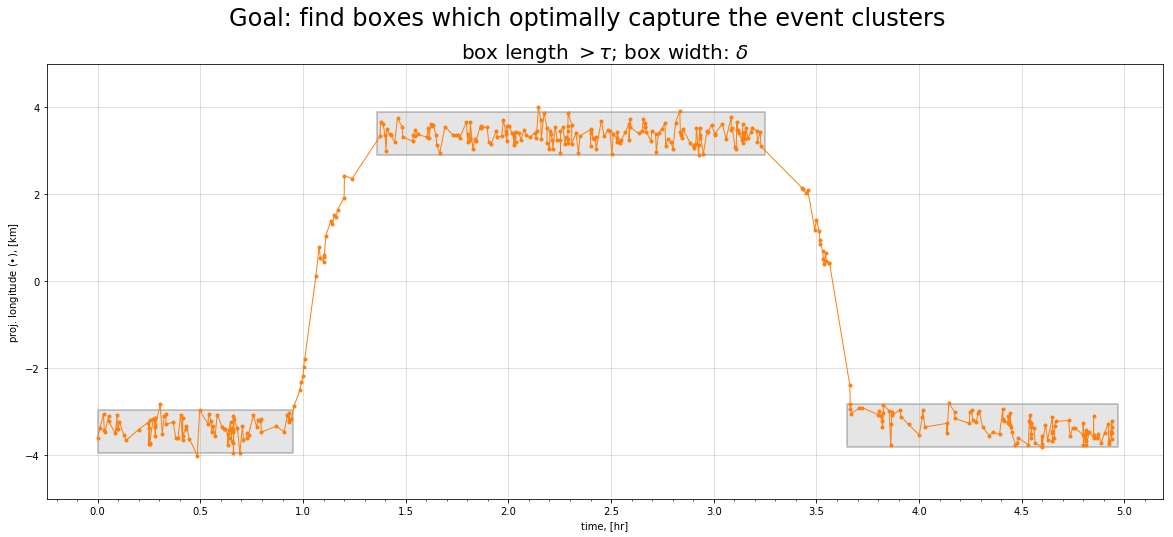

In [161]:
fig, ax = plt.subplots(1,1, figsize=[20,8])

ax.plot(stamps, nplons, '.-', color='C1', lw=1, label='raw')

# Boxes
box_dict = dict(facecolor='gray', alpha=0.2, edgecolor='k',linewidth=2)
draw_bin(1.36,  3.40, 1.89, 0.5, box_dict, ax)
draw_bin(0.00, -3.45, 0.95, 0.5, box_dict, ax)
draw_bin(3.65, -3.32, 1.32, 0.5, box_dict, ax)

axes_settings(ax)
ax.set_title(r'box length $> \tau$; box width: $\delta$', fontsize=20)
fig.suptitle('Goal: find boxes which optimally capture the event clusters', fontsize=24);
fig.savefig('goal_of_the_boxes.png', layout='tight')

### Two strategies

Generally speaking, there are two strategies which can be pursued:
- box short event sequences, and then increase the box
- optimally place boxes of the entire duration, and then shrink

During and after these processes, there should be refinements to optimize the box placement.

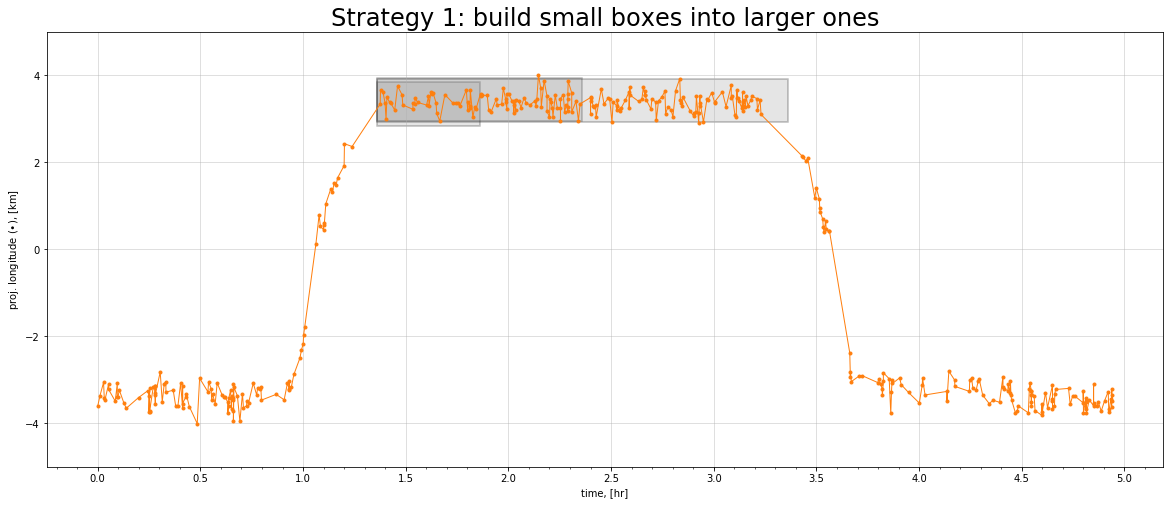

In [162]:
fig, ax = plt.subplots(1,1, figsize=[20,8])

ax.plot(stamps, nplons, '.-', color='C1', lw=1, label='raw')

# Boxes
draw_bin(1.36, 3.34, 0.50, 0.5, box_dict, ax)
draw_bin(1.36, 3.45, 1.00, 0.5, box_dict, ax)
draw_bin(1.36, 3.42, 2.00, 0.5, box_dict, ax)

axes_settings(ax)
ax.set_title('Strategy 1: build small boxes into larger ones', fontsize=24)
fig.savefig('growing_the_boxes.png', layout='tight');

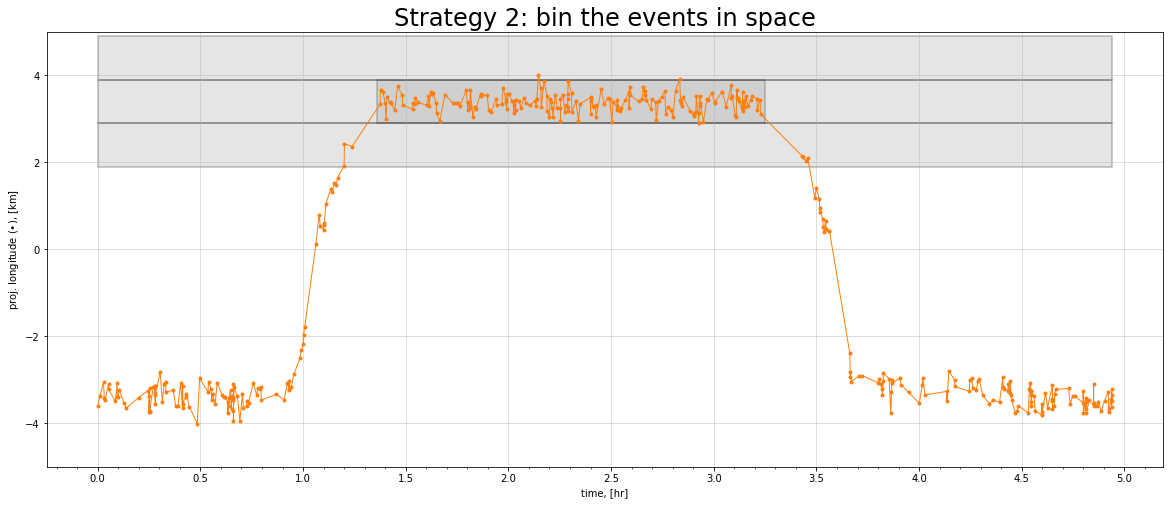

In [167]:
fig, ax = plt.subplots(1,1, figsize=[20,8])

ax.plot(stamps, nplons, '.-', color='C1', lw=1, label='raw')

# Boxes
box_dict = dict(facecolor='gray', alpha=0.2, edgecolor='k',linewidth=2)
draw_bin(1.36,  3.40, 1.89, 0.5, box_dict, ax)
draw_bins(stamps[0], 2.4, stamps[-1]-stamps[0], 0.5, 3, box_dict, ax)

axes_settings(ax)
ax.set_title('Strategy 2: bin the events in space', fontsize=24)
fig.savefig('binning_the_events.png', layout='tight');

In [164]:
def arrows_and_text(loc, ax):

    # Double arrows
    arrowprops=dict(arrowstyle="<->", 
                    shrinkA=0.5,
                    mutation_scale=30.0,
                    connectionstyle="arc3", linewidth=4.0)
    arrowcentery = loc
    arrowcenterx = 2.3
    arrowcenterh = 2*eps
    ax.annotate("", xy=(arrowcenterx, arrowcentery-arrowcenterh), \
                    xytext=(arrowcenterx, arrowcentery+arrowcenterh), \
                    arrowprops=arrowprops)

    dt_arrowcentery = eps
    ax.annotate("", xy=(begin_buff, arrowcentery-dt_arrowcentery), \
                    xytext=(begin, arrowcentery-dt_arrowcentery), \
                    arrowprops=arrowprops)

    ax.annotate("", xy=(end, arrowcentery-dt_arrowcentery), \
                    xytext=(end_buff, arrowcentery-dt_arrowcentery), \
                    arrowprops=arrowprops)

    # Annotations
    arrowprops=dict(arrowstyle="->", color="0.5",
                    shrinkA=5, shrinkB=5,
                    patchA=None, patchB=None,
                    connectionstyle="arc3,rad=-0.3", linewidth=2.0)

    delta_t_texty = 0.4

    mid_point = lambda x1,x2: 0.5*(x1+x2)


    anno_dict = dict(fontsize= 24,textcoords='data', xycoords='data')
    ax.annotate(r"Adjust by $\tau$",
                xy=(mid_point(begin,begin_buff)-0.1, 3.3),
                xytext=(begin-1.5,delta_t_texty),
                **anno_dict, arrowprops=arrowprops)

    arrowprops['connectionstyle']="arc3,rad=0.3"


    ax.annotate("Extending box\n makes no difference\n" + \
                "in stay location\n and event count",
                xy=(mid_point(end,end_buff)+0.6, 3.5),
                xytext=(end+0.65, delta_t_texty-1.0),
                **anno_dict, arrowprops=arrowprops)

    ax.annotate(s=r"Adjust $x$-position "+"of box\n to contain max events",
                xy=(arrowcenterx+0.05, arrowcentery-0.1),
                xytext=(arrowcenterx-0.6, arrowcentery-5.0),
                **anno_dict, arrowprops=arrowprops)    

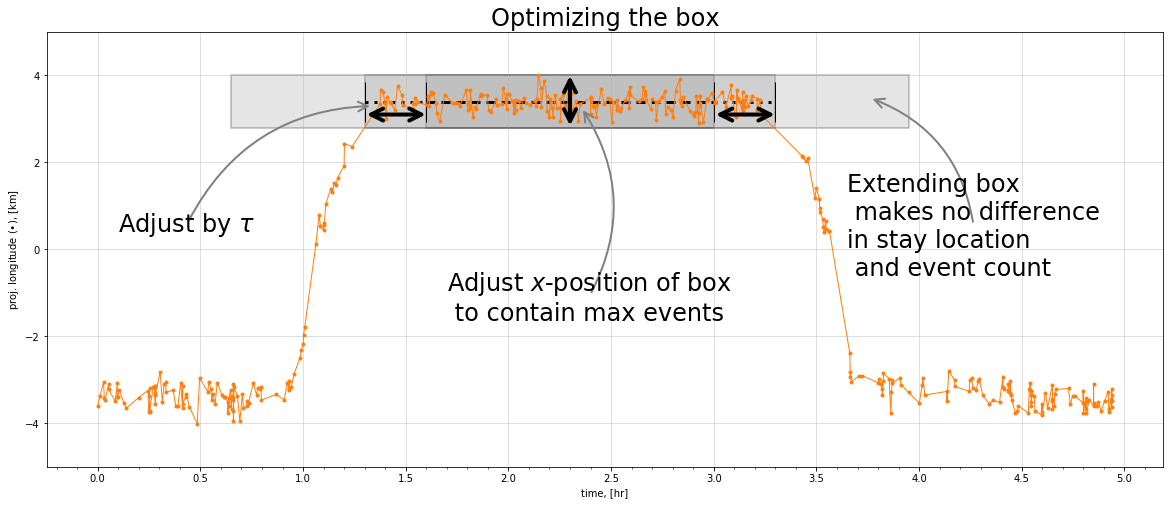

In [165]:
fig, ax = plt.subplots(1,1, figsize=[20,8])

eps = 0.3
begin = 1.6
begin_buff = begin-0.3
end = 3.0
end_buff = end+0.3

loc = 3.4

# Plot dashed lines and edges
ax.plot([begin,end], [loc,loc], 'k--', dashes=[3,2], linewidth=3.0)
ax.plot([begin_buff,begin], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)
ax.plot([end,end_buff], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)

# Plot trajectory
ax.plot(stamps, nplons, '.-', color='C1', lw=1, label='raw')

# Plot boxes
draw_bin(begin,        loc, end-begin, 2*eps, box_dict, ax)
draw_bin(begin_buff,   loc, end_buff-begin_buff, 2*eps, box_dict, ax)
draw_bin(begin_buff/2, loc, end+(begin-begin_buff), 2*eps, box_dict, ax)

# Add annotations
arrows_and_text(loc, ax)

axes_settings(ax)
ax.set_title('Optimizing the box', fontsize=24);

fig.savefig('refining_the_box.png', layout='tight')